In [1]:
%config InlineBackend.figure_format = 'retina'
%config IPCompleter.use_jedi = False

import os
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd

from daskdecorators import dask_hist
import hist
from hist import Hist

import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams['savefig.dpi'] = 120
matplotlib.rcParams['figure.dpi'] = 120

In [3]:
import multiprocessing.popen_spawn_posix # For python 3.9
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=6, 
                       threads_per_worker=1,
                       memory_limit='5Gb')
client = Client(cluster)

#dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status"
#client = Client(scheduler_file='/global/cscratch1/sd/cwalter/dask-mpi/scheduler.json')

client

Client Scheduler: tcp://127.0.0.1:61625 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 6 Memory: 30.00 GB


In [4]:
#scratch= os.environ["SCRATCH"]
scratch = '/Users/walter/LSST/work'

selected = ['id', 'mag_r', 'z', 'ra', 'dec', 'g1', 'g2']

#df = dd.read_parquet(f'{scratch}/parquet-skysim/*.parquet', columns=selected, engine='pyarrow')
df = dd.read_parquet(f'{scratch}/skysim-sampled', columns=selected, engine='pyarrow')
#df = df.persist()

print('Columns:', df.columns.values, '#Rows:', df.z.size.compute()/1e9)

Columns: ['id' 'mag_r' 'z' 'ra' 'dec' 'g1' 'g2'] #Rows: 0.0626302


In [5]:
from scipy.special import comb

#small_area = df.query('40 < ra < 44 and -34 < dec < -30 and mag_r < 26').sample(frac=.008)
small_area = df.query('0 < ra < 4 and -4 < dec < 0 and mag_r < 26').sample(frac=0.15).persist()

number_in_sample = small_area.index.size.compute()
print(f'There are {df.index.size.compute():,d} elements in the Sky Sim')
print(f'There are {number_in_sample:,d} elements in the small area with {comb(number_in_sample, 2, exact=True):,d} combinations')

ra = small_area.ra.compute().to_numpy()
dec = small_area.dec.compute().to_numpy()
g1 = small_area.g1.compute().to_numpy()
g2 = -small_area.g2.compute().to_numpy()

There are 62,630,200 elements in the Sky Sim
There are 6,607 elements in the small area with 21,822,921 combinations


In [6]:
%%time
from numpy import deg2rad, pi
import itertools as it

from astropy.coordinates.angle_utilities import angular_separation
from astropy.coordinates.angle_utilities import position_angle

positions = np.column_stack([deg2rad(ra), deg2rad(dec), g1, g2])
pairs = np.array( list(it.combinations(positions, 2)) )

ra1, dec1, g1_1, g2_1 = pairs[:,0,0], pairs[:,0,1], pairs[:,0,2], pairs[:,0,3]
ra2, dec2, g1_2, g2_2 = pairs[:,1,0], pairs[:,1,1], pairs[:,1,2], pairs[:,1,3]

separation = angular_separation(ra1, dec1, ra2, dec2)*180/pi*60
angle = position_angle(ra1, dec1, ra2, dec2).rad

gamma1 = g1_1 + g2_1*1j
gamma2 = g1_2 + g2_2*1j
rotation = np.exp(-2j*angle)

gt_1, gc_1 = -(gamma1*rotation).real, -(gamma1*rotation).imag
gt_2, gc_2 = -(gamma2*rotation).real, -(gamma2*rotation).imag

tt = gt_1*gt_2
cc = gc_1*gc_2
tc = gt_1*gc_2

xip = tt + cc
xim = tt - cc

# Alternatively.  xip is real part of [eqn 32 of https://arxiv.org/pdf/1411.0115.pdf]
gamma_gamma = gamma1 * gamma2.conjugate()

CPU times: user 33.4 s, sys: 3.26 s, total: 36.7 s
Wall time: 36.2 s


In [27]:
%%script echo Skipping Cell

sep_hist = Hist.new.Reg(100, 0, 300, name='Theta').Double()
phi_hist = Hist.new.Reg(100, 0, 360, name='Phi').Double()

sep_hist.fill(separation);
phi_hist.fill(angle*180/pi);

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(4.5, 2))

fig.suptitle('Separation and Orientation of Galaxy Pairs')
sep_hist.plot(ax=ax1)
ax1.set_xscale('log')
ax1.set_ylabel('Counts')
ax1.set_xlabel(r'$\theta$ (arcmin)')

phi_hist.plot(ax=ax2)
ax2.set_xlabel(r'$\phi$');

Skipping Cell


In [8]:
%%time

import treecorr

cat = treecorr.Catalog(ra=ra, dec=dec, g1=g1, g2=g2, ra_units='deg', dec_units='deg')
gg = treecorr.GGCorrelation(min_sep=1., max_sep=200., nbins=20, sep_units='arcmin', brute=True)
gg.process(cat)

CPU times: user 2.04 s, sys: 40.9 ms, total: 2.08 s
Wall time: 286 ms


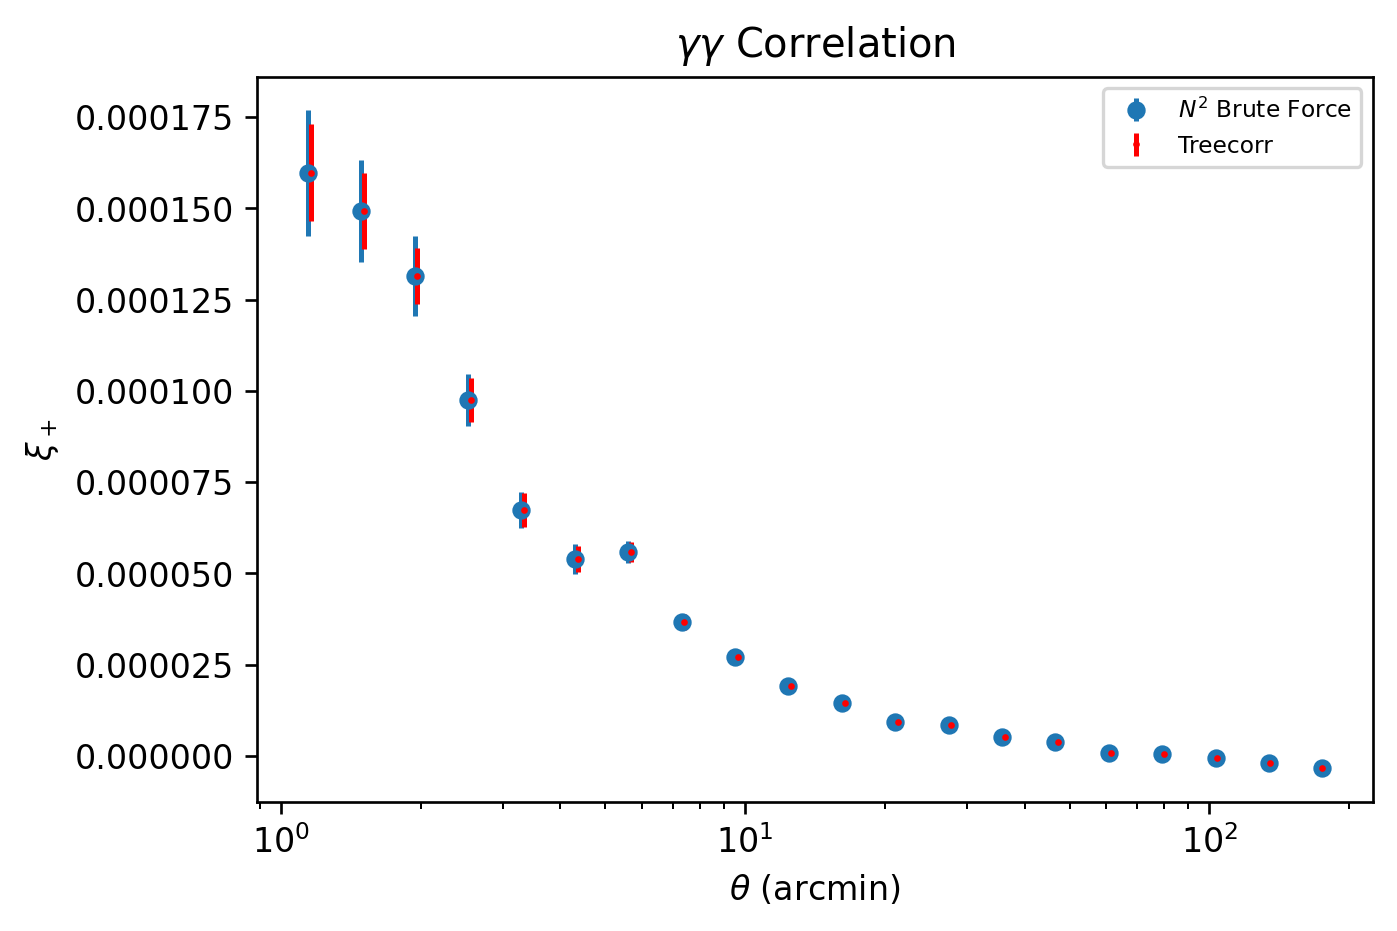

In [19]:
xip_hist = Hist.new.Reg(20, 1, 200, name='XP', transform=hist.axis.transform.log).Mean()
xip_hist.fill(separation, sample=xip)

xim_hist = Hist.new.Reg(20, 1, 200, name='XM', transform=hist.axis.transform.log).Mean()
xim_hist.fill(separation, sample=xim)

centers = xip_hist.axes.centers[0]
xip_results = xip_hist.view()
xip_values = xip_results.value
xip_errors = np.sqrt(xip_results.variance/xip_results.count)
plt.errorbar(x=centers, y=xip_values, yerr=xip_errors, fmt='.', markersize=9, label='$N^2$ Brute Force')

plt.title('$\gamma \gamma$ Correlation')
plt.xscale('log')
#plt.yscale('log')
#plt.ylim(bottom=0.5e-6)
plt.ylabel(r'$\xi_+$')
plt.xlabel(r'$\theta$ (arcmin)')
plt.errorbar(gg.meanr, gg.xip, yerr=np.sqrt(gg.varxip), color='red',marker='.',markersize=2, ls='none', label='Treecorr')
plt.legend(prop={'size': 7})